# Elevator System Design Strategy Analysis

The purpose of this document is to compare and contrast the behaviors of the various strategies implemented within this design. See the readme for detailed explanations of each strategy.

## Assorted installs

In [1]:
! pip install seaborn pandas
import pandas as pd
import numpy as np
import seaborn as sns
import logging
from matplotlib import pyplot as plt

from elevator_system_design.model.elevator import Elevator
from elevator_system_design.elevator_controller import ElevatorController
from elevator_system_design.log import logger
from elevator_system_design.passenger_providers import random_normal_floor_selection_passenger_provider, \
    random_uniform_floor_selection_passenger_provider
from elevator_system_design.strategies.assignment import ExistingStopStrategy, ExistingStopPreferenceStrategy, DirectionalStrategy, ClosestEmptyStrategy
from elevator_system_design.strategies.elevator_controller_persistence import CsvPersistenceStrategy
from elevator_system_design.strategies.idle import EqualSpreadIdleStrategy, HistoricalDistributionIdleStrategy

logging.getLogger().setLevel(level=logging.CRITICAL)

You should consider upgrading via the '/Users/patricklaflamme/Projects/elevator-system-design/venv/bin/python -m pip install --upgrade pip' command.


## Analysis Specific Class and Function Definitions

### Define a pandas-specific persistence strategy for subsequent analysis

Here we leverage the ElevatorControllerPersistenceStrategy protocol to define a custom elevator persistence strategy. This allows us to output the elevators' locations at each time point to a dataframe for further analysis.

In [2]:
from typing import List, Optional

class PandasPersistenceStrategy():
    df: Optional[pd.DataFrame] = None
    def persist(self, t: int, elevators: List[Elevator]):
        if self.df is None:
            self.df = pd.DataFrame(columns=["time",*[f"elevator_{i}" for i in range(len(elevators))]])
        self.df.loc[-1] = [t, *[e.current_floor for e in elevators]]
        self.df.index = self.df.index + 1
        self.df.sort_index()

### Define a function to visualize elevator locations in a heatmap.

In [3]:
def elevator_heat_map(locations: pd.DataFrame):
    elevator_vars = [c for c in locations.columns if c.startswith("elevator_")]
    assert "time" in locations.columns
    assert len(elevator_vars) > 0
    melted = locations.melt(id_vars=["time"], value_name="floor", var_name="elevator")\
        .groupby(["floor", "elevator"]).count().rename(columns={"time": "count"})\
        .reset_index()\
        .set_index(['floor','elevator'])\
        .unstack()['count']\
        .sort_index(ascending=False)\
        .fillna(0)
    sns.heatmap(melted)
    plt.show()

### Define a convenience function to print to markdown.

In [4]:
from IPython.display import display, Markdown, HTML

def pmark(s: str):
    display(Markdown(s))

def phtml(s: str):
    display(HTML(s))


## Analysis

### Uniform Passenger Floor Selection

In [15]:
def test_strategies_for_uniform_passenger_floors(assignment_strategy, idle_strategy, stop_time, seed=1231235):
    n_floors = 60
    n_elevators = 3
    max_elevator_capacity = 5
    np.random.seed(seed)
    passenger_provider = random_uniform_floor_selection_passenger_provider(
        n=5,
        p=0.2,
        n_steps=100,
        n_floors=n_floors
    )
    state_persistence = PandasPersistenceStrategy()
    elevator_system = ElevatorController(
        n_elevators=n_elevators,
        n_floors=n_floors,
        max_elevator_capacity=max_elevator_capacity,
        persistence_strategy=state_persistence,
        assignment_strategy=assignment_strategy,
        idle_strategy=idle_strategy,
        stop_time=stop_time
    )
    elevator_system.handle_passenger_requests(passenger_request_source=passenger_provider)
    print(f"total steps: {elevator_system.time}")
    elevator_system.print_stats(print_func=phtml, table_fmt="html")
    elevator_heat_map(state_persistence.df)
    print("\n\n")

#### Strategy comparison assuming no time for passengers to embark/disembark

#### Existing Stop Assignment & Equal Spread Idle Strategies

total steps: 302


time_period,min,max,mean,n_passengers,no_action_passengers
wait time,1,270,82.901,101,0
total time,4,292,105.881,101,0


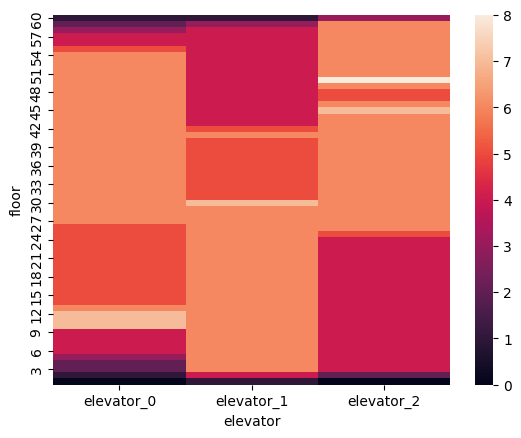

#### Existing Stop Preference Assignment & Equal Spread Idle Strategies

total steps: 302


time_period,min,max,mean,n_passengers,no_action_passengers
wait time,1,270,82.901,101,0
total time,4,292,105.881,101,0


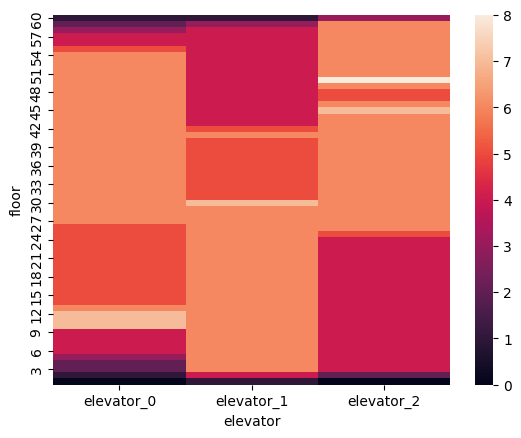

#### Directional Assignment & Equal Spread

total steps: 461


time_period,min,max,mean,n_passengers,no_action_passengers
wait time,0,391,104.366,101,0
total time,4,417,127.347,101,0


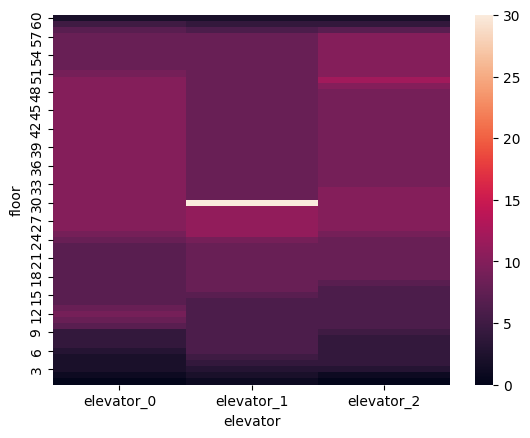

#### Nearest Idle Elevator & Equal Spread Strategies

total steps: 1515


time_period,min,max,mean,n_passengers,no_action_passengers
wait time,1,1398,639.079,101,0
total time,11,1415,662.059,101,0


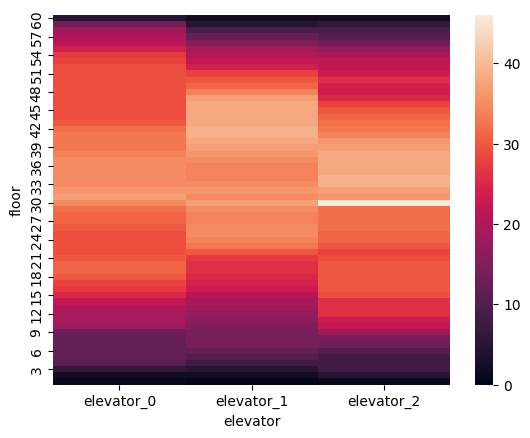

In [18]:
stop_time = 0
pmark("#### Existing Stop Assignment & Equal Spread Idle Strategies")
test_strategies_for_uniform_passenger_floors(ExistingStopStrategy(), EqualSpreadIdleStrategy(), stop_time)
pmark("#### Existing Stop Preference Assignment & Equal Spread Idle Strategies")
test_strategies_for_uniform_passenger_floors(ExistingStopPreferenceStrategy(), EqualSpreadIdleStrategy(), stop_time)
pmark("#### Directional Assignment & Equal Spread")
test_strategies_for_uniform_passenger_floors(DirectionalStrategy(), EqualSpreadIdleStrategy(), stop_time)
pmark("#### Nearest Idle Elevator & Equal Spread Strategies")
test_strategies_for_uniform_passenger_floors(ClosestEmptyStrategy(), EqualSpreadIdleStrategy(), stop_time)

#### Strategy comparison assuming no time for passengers to embark/disembark

#### Existing Stop Assignment & Equal Spread Idle Strategies

total steps: 454


time_period,min,max,mean,n_passengers,no_action_passengers
wait time,1,366,143.099,101,0
total time,6,389,180.97,101,0


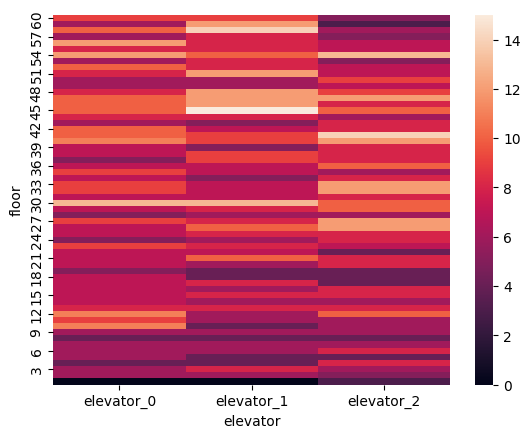

#### Existing Stop Preference Assignment & Equal Spread Idle Strategies

total steps: 454


time_period,min,max,mean,n_passengers,no_action_passengers
wait time,1,366,143.099,101,0
total time,6,389,180.97,101,0


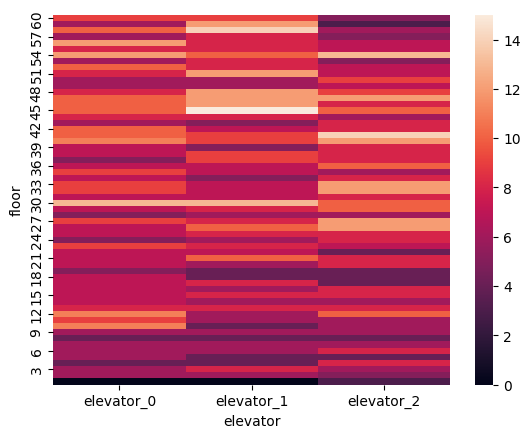

#### Directional Assignment & Equal Spread

total steps: 573


time_period,min,max,mean,n_passengers,no_action_passengers
wait time,0,539,158.485,101,0
total time,6,559,198.673,101,0


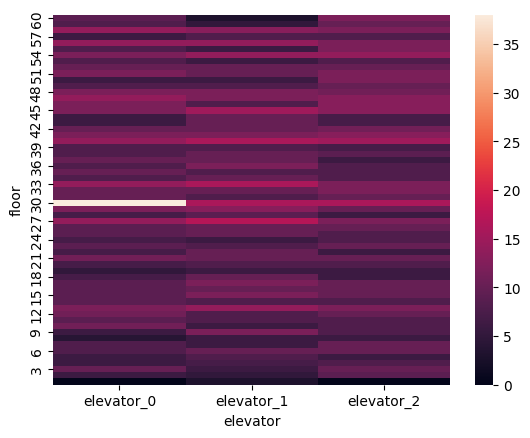

#### Nearest Idle Elevator & Equal Spread Strategies

total steps: 1665


time_period,min,max,mean,n_passengers,no_action_passengers
wait time,1,1546,701.059,101,0
total time,13,1565,726.04,101,0


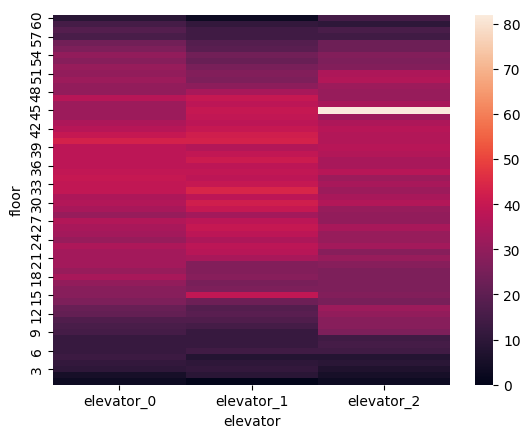

In [17]:
stop_time = 2
pmark("#### Existing Stop Assignment & Equal Spread Idle Strategies")
test_strategies_for_uniform_passenger_floors(ExistingStopStrategy(), EqualSpreadIdleStrategy(), stop_time)
pmark("#### Existing Stop Preference Assignment & Equal Spread Idle Strategies")
test_strategies_for_uniform_passenger_floors(ExistingStopPreferenceStrategy(), EqualSpreadIdleStrategy(), stop_time)
pmark("#### Directional Assignment & Equal Spread")
test_strategies_for_uniform_passenger_floors(DirectionalStrategy(), EqualSpreadIdleStrategy(), stop_time)
pmark("#### Nearest Idle Elevator & Equal Spread Strategies")
test_strategies_for_uniform_passenger_floors(ClosestEmptyStrategy(), EqualSpreadIdleStrategy(), stop_time)

#### Why is the existing stop strategy better?

The existing stop strategy is better because it considers not just whether an elevator is moving in the same direction, but also which stops are already being considered along the way. By necessity, this also forcasts how long the passenger will wait before being picked up, including time spent waiting for passengers to embark/disembark. As the stop time increases, the superiority of the `Existing Stop Assignment Strategy` becomes more apparent.

### Normally Distributed Passenger Floor Selection

In [33]:
n_floors = 60

def historical_strategy_with_normal_hist(n_samples=10000, seed=1231235):
    np.random.seed(seed)
    historical_passenger_provider = random_normal_floor_selection_passenger_provider(
        n=5,
        p=0.2,
        n_steps=n_samples,
        n_floors=n_floors,
        source_mean_floor=n_floors // 5,
        source_std=n_floors // 8,
        destination_mean_floor=4 * n_floors // 5,
        destination_std=n_floors // 8,
    )
    historical_dist = [0 for _ in range(n_floors)]
    for step in historical_passenger_provider:
        for p in step:
            historical_dist[p.source_floor - 1] += 1
    return HistoricalDistributionIdleStrategy(historical_counts=historical_dist)


def test_strategies_for_normal_passenger_floors(assignment_strategy, idle_strategy, stop_time, n_elevators, seed=1231235):
    n_floors = 60
    n_elevators = n_elevators
    max_elevator_capacity = 5
    np.random.seed(seed)
    passenger_provider = random_normal_floor_selection_passenger_provider(
        n=5,
        p=0.2,
        n_steps=100,
        n_floors=n_floors,
        source_mean_floor=n_floors // 5,
        source_std=n_floors // 8,
        destination_mean_floor=4 * n_floors // 5,
        destination_std=n_floors // 8,
    )
    state_persistence = PandasPersistenceStrategy()
    elevator_system = ElevatorController(
        n_elevators=n_elevators,
        n_floors=n_floors,
        max_elevator_capacity=max_elevator_capacity,
        persistence_strategy=state_persistence,
        assignment_strategy=assignment_strategy,
        idle_strategy=idle_strategy,
        stop_time=stop_time
    )
    elevator_system.handle_passenger_requests(passenger_request_source=passenger_provider)
    print(f"total steps: {elevator_system.time}")
    elevator_system.print_stats(print_func=phtml, table_fmt="html")
    elevator_heat_map(state_persistence.df)
    print("\n\n")

#### Distribution of historical data

<Axes: ylabel='Count'>

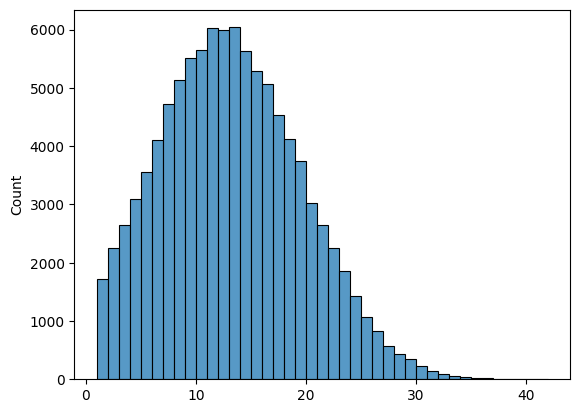

In [35]:

hist_strat = historical_strategy_with_normal_hist(n_samples=100000)

sns.histplot(hist_strat.historical_counts, binwidth=1)

#### Few elevators

#### Existing Stop Assignment & Historical Spread Strategies

total steps: 741


time_period,min,max,mean,n_passengers,no_action_passengers
wait time,1,709,326.366,101,0
total time,7,713,373.228,101,0


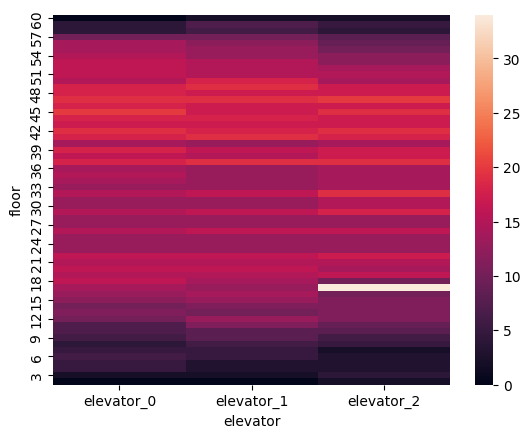

#### Existing Stop Assignment & Equal Spread Strategies

total steps: 756


time_period,min,max,mean,n_passengers,no_action_passengers
wait time,1,697,330.703,101,0
total time,5,718,380.614,101,0


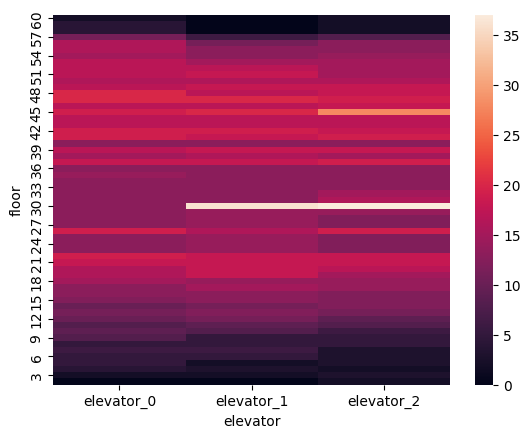

In [38]:
stop_time = 1
n_elevators = 3

pmark("#### Existing Stop Assignment & Historical Spread Strategies")
test_strategies_for_normal_passenger_floors(ExistingStopStrategy(), hist_strat, stop_time, n_elevators)
pmark("#### Existing Stop Assignment & Equal Spread Strategies")
test_strategies_for_normal_passenger_floors(ExistingStopStrategy(), EqualSpreadIdleStrategy(), stop_time, n_elevators)

#### Many Elevators

#### Existing Stop Assignment & Historical Spread Strategies

total steps: 187


time_period,min,max,mean,n_passengers,no_action_passengers
wait time,1,51,21.4554,101,0
total time,8,112,62.6337,101,0


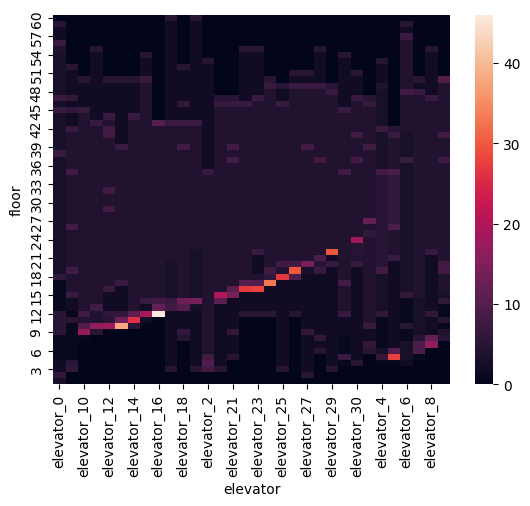

#### Existing Stop Assignment & Equal Spread Strategies

total steps: 179


time_period,min,max,mean,n_passengers,no_action_passengers
wait time,1,49,20.396,101,0
total time,10,109,60.3861,101,0


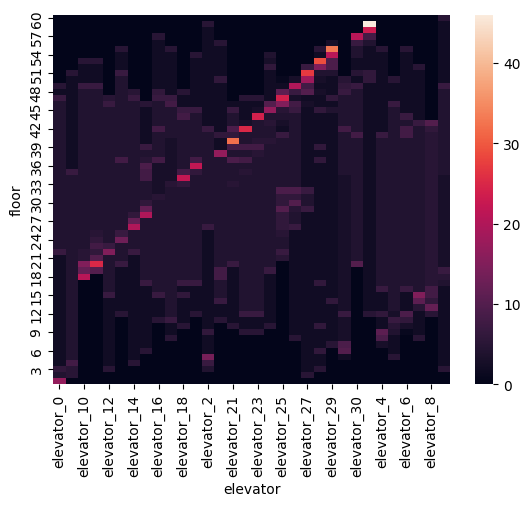

In [40]:
stop_time = 4
n_elevators = 32
hist_strat = historical_strategy_with_normal_hist()

pmark("#### Existing Stop Assignment & Historical Spread Strategies")
test_strategies_for_normal_passenger_floors(ExistingStopPreferenceStrategy(), hist_strat, stop_time, n_elevators)
pmark("#### Existing Stop Assignment & Equal Spread Strategies")
test_strategies_for_normal_passenger_floors(ExistingStopPreferenceStrategy(), EqualSpreadIdleStrategy(), stop_time, n_elevators)